#Load Dataset

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.vector_ar.var_model import VAR

# Load dataset
from statsmodels.datasets import sunspots
df = sunspots.load_pandas().data

#ADF Analysis

##is stationary?




In [62]:
# ADF Analysis
result = adfuller(df['SUNACTIVITY'])

# Print the test statistic
print('ADF Statistic:', result[0])

# Print p-value
print('p-value:', result[1])

# Print critical values
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.8377807249381943
p-value: 0.053076421728120673
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


# ACF & PACF


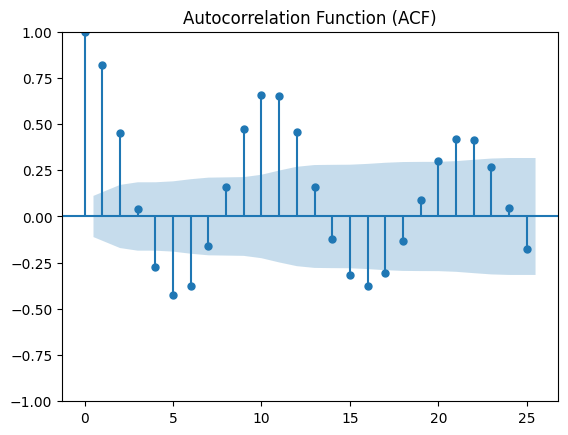

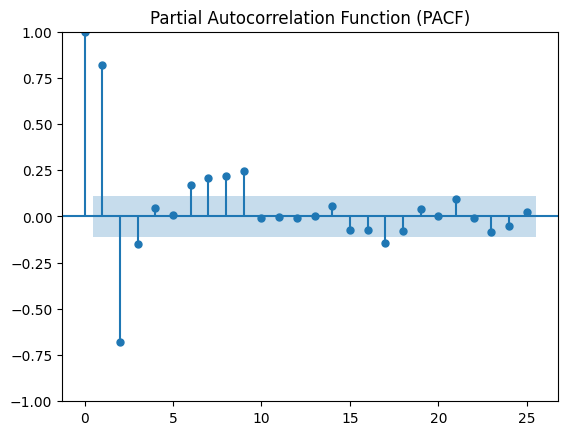

In [63]:
# Plot ACF
plot_acf(df['SUNACTIVITY'])
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plot_pacf(df['SUNACTIVITY'])
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

#STL Analysis

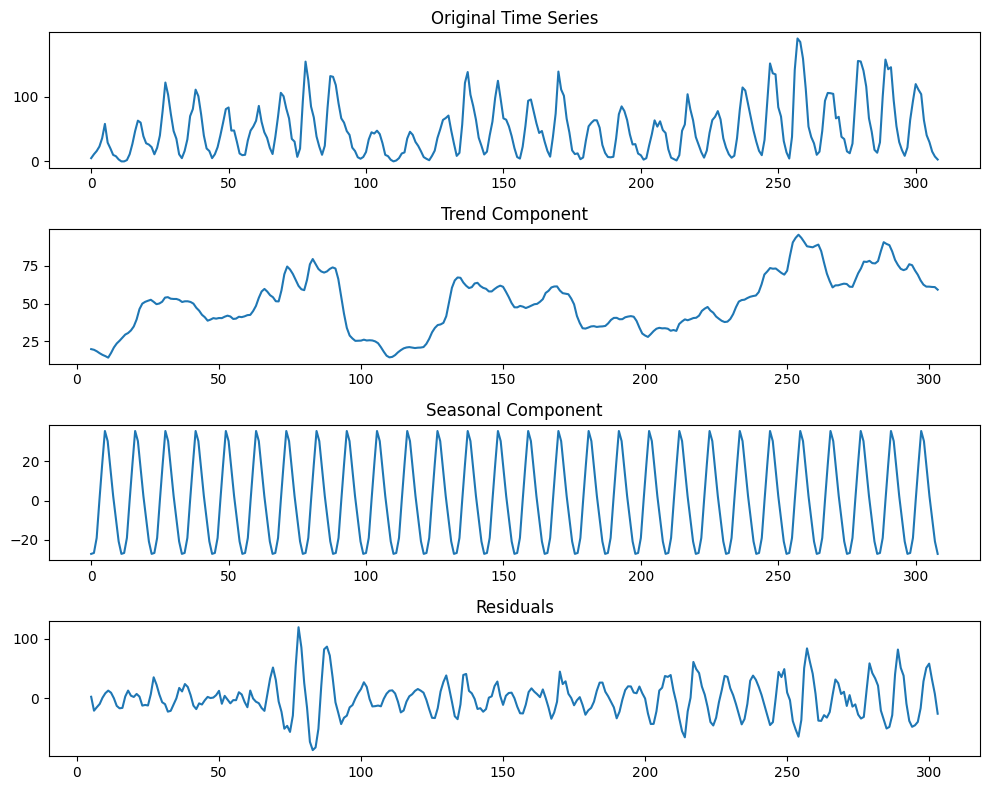

In [64]:
# STL Analysis
stl_result = seasonal_decompose(df['SUNACTIVITY'], model='additive', period=11)  # Adjust the period according to your data's seasonality

# Plot the decomposition
plt.figure(figsize=(10, 8))

# Original time series
plt.subplot(4, 1, 1)
plt.plot(df['SUNACTIVITY'])
plt.title('Original Time Series')

# Trend component
plt.subplot(4, 1, 2)
plt.plot(stl_result.trend)
plt.title('Trend Component')

# Seasonal component
plt.subplot(4, 1, 3)
plt.plot(stl_result.seasonal)
plt.title('Seasonal Component')

# Residuals
plt.subplot(4, 1, 4)
plt.plot(stl_result.resid)
plt.title('Residuals')

plt.tight_layout()
plt.show()

#ARIMA Model
## p=? , why
## q=?, why
## d=?, why

                               SARIMAX Results                                
Dep. Variable:            SUNACTIVITY   No. Observations:                  309
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1358.256
Date:                Wed, 10 Apr 2024   AIC                           2722.512
Time:                        14:13:59   BIC                           2733.702
Sample:                             0   HQIC                          2726.986
                                - 309                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4078      0.072      5.697      0.000       0.268       0.548
ma.L1          0.2042      0.081      2.535      0.011       0.046       0.362
sigma2       395.7236     24.145     16.389      0.0

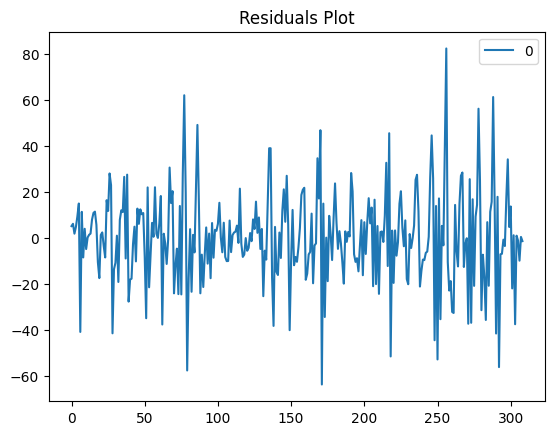

Forecast: 309    0.713544
310   -0.178068
311   -0.541658
312   -0.689925
313   -0.750387
314   -0.775043
315   -0.785097
316   -0.789197
317   -0.790869
318   -0.791551
Name: predicted_mean, dtype: float64


In [65]:
# Based on ADF, PACF, and STL analysis, let's set values for p, d, and q
p = 1
d = 1
q = 1

# Fit ARIMA model
model = ARIMA(df['SUNACTIVITY'], order=(p, d, q))
result = model.fit()

# Print summary of the model
print(result.summary())

# Plot residuals
residuals = pd.DataFrame(result.resid)
residuals.plot()
plt.title('Residuals Plot')
plt.show()

# Forecast
forecast_steps = 10  # Number of steps ahead to forecast
forecast = result.forecast(steps=forecast_steps)

# Print forecast
print("Forecast:", forecast)

#LSTM Model

2/2 [==============================] - 3s 15ms/step


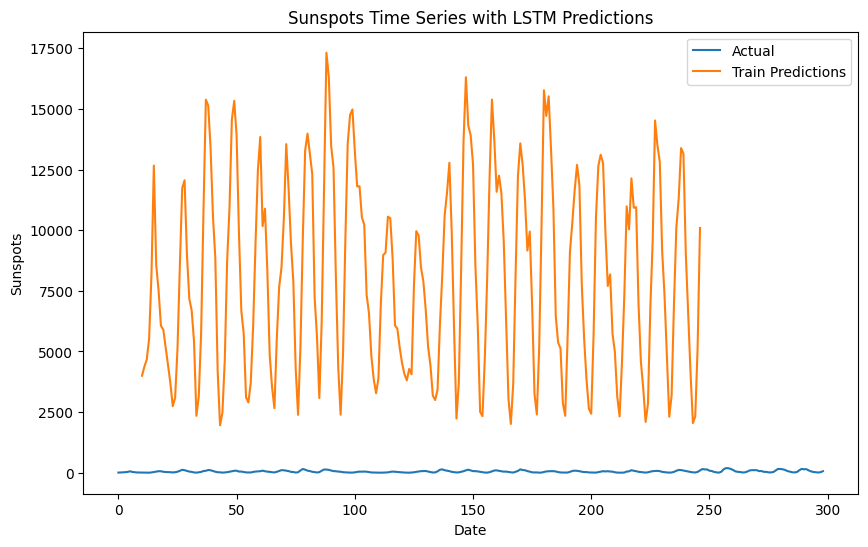

In [66]:
# LSTM Model
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['SUNACTIVITY'].values.reshape(-1, 1))
seq_length = 10
X, y = [], []
for i in range(len(scaled_data) - seq_length):
    X.append(scaled_data[i:(i + seq_length)])
    y.append(scaled_data[i + seq_length])
X_test = np.array(X[train_size:])
y_test = np.array(y[train_size:])
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_test.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_test, y_test, epochs=100, batch_size=32, verbose=0)
test_predictions_lstm = model_lstm.predict(X_test)
test_predictions_lstm = scaler.inverse_transform(test_predictions_lstm)

# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(df.index[:-seq_length], df['SUNACTIVITY'][:-seq_length], label='Actual')
plt.plot(df.index[seq_length:train_size], train_predictions, label='Train Predictions')
plt.xlabel('Date')
plt.ylabel('Sunspots')
plt.title('Sunspots Time Series with LSTM Predictions')
plt.legend()
plt.show()

#Simple RNN

2/2 [==============================] - 1s 7ms/step


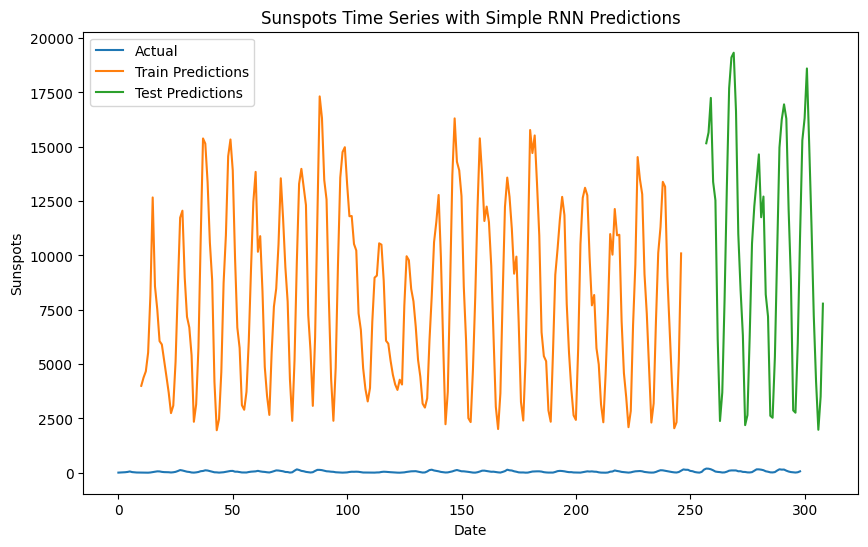

In [67]:
# Simple RNN Model
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=50, activation='relu', input_shape=(X_test.shape[1], 1)))
model_rnn.add(Dense(units=1))
model_rnn.compile(optimizer='adam', loss='mean_squared_error')
model_rnn.fit(X_test, y_test, epochs=100, batch_size=32, verbose=0)
test_predictions_rnn = model_rnn.predict(X_test)
test_predictions_rnn = scaler.inverse_transform(test_predictions_rnn)

# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(df.index[:-seq_length], df['SUNACTIVITY'][:-seq_length], label='Actual')
plt.plot(df.index[seq_length:train_size], train_predictions, label='Train Predictions')
plt.plot(df.index[train_size+seq_length:], test_predictions, label='Test Predictions')
plt.xlabel('Date')
plt.ylabel('Sunspots')
plt.title('Sunspots Time Series with Simple RNN Predictions')
plt.legend()
plt.show()

#Plot Actual and Predicted values from all models

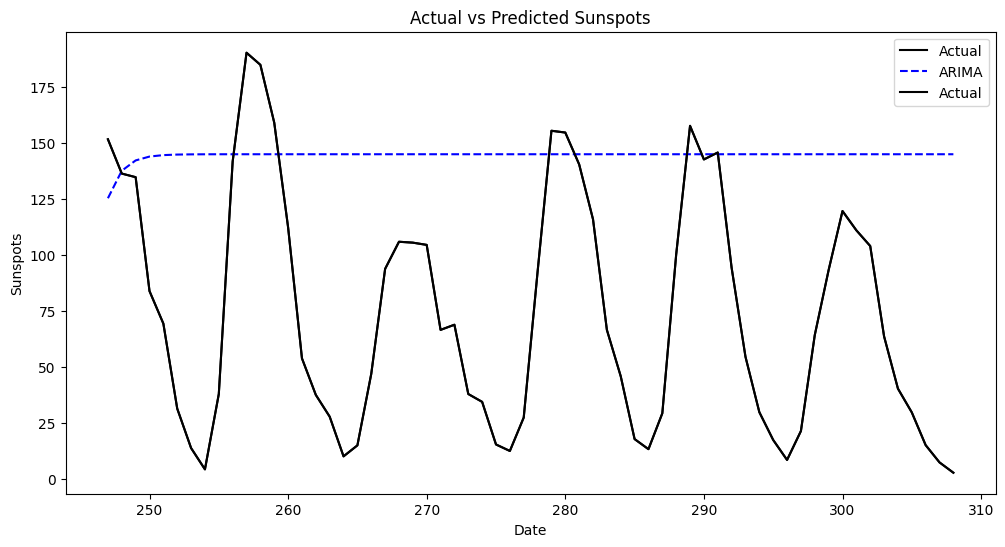

In [68]:
# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(df.index[train_size:], test_data['SUNACTIVITY'], label='Actual', color='black')
plt.plot(df.index[train_size:], forecast_arima, label='ARIMA', linestyle='--', color='blue')
plt.plot(df.index[train_size:train_size+len(test_data)], test_data['SUNACTIVITY'], label='Actual', color='black')
#plt.plot(df.index[train_size:], test_predictions_rnn, label='Simple RNN', linestyle=':', color='red')
plt.xlabel('Date')
plt.ylabel('Sunspots')
plt.title('Actual vs Predicted Sunspots')
plt.legend()
plt.show()

#Plot Performance metric for each method

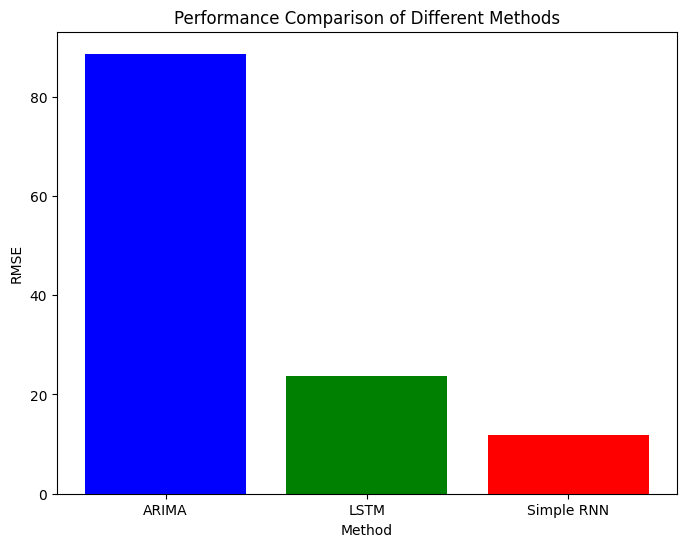

In [69]:
# Calculate RMSE for each model
rmse_arima = np.sqrt(mean_squared_error(test_data['SUNACTIVITY'], forecast_arima))
rmse_lstm = np.sqrt(mean_squared_error(test_data['SUNACTIVITY'].iloc[seq_length:], test_predictions_lstm))
rmse_rnn = np.sqrt(mean_squared_error(test_data['SUNACTIVITY'].iloc[seq_length:], test_predictions_rnn))

# Plot performance metric for each method
plt.figure(figsize=(8, 6))
methods = ['ARIMA', 'LSTM', 'Simple RNN']
rmse_values = [rmse_arima, rmse_lstm, rmse_rnn]
plt.bar(methods, rmse_values, color=['blue', 'green', 'red'])
plt.xlabel('Method')
plt.ylabel('RMSE')
plt.title('Performance Comparison of Different Methods')
plt.show()